# DECISION ALGORITHM 1: Q-Learning (Core RL Baseline)

In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


## 1A. Classical Q-Learning

Topic: Sequential strategic decision-making

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pennylane as qml


In [3]:
N_STATES = 5
N_ACTIONS = 2
EPISODES = 200
STEPS_PER_EPISODE = 20
GAMMA = 0.95
ALPHA = 0.1


In [4]:
def env_step(state, action):
    reward_probs = [0.4, 0.6]
    reward = 1 if np.random.rand() < reward_probs[action] else 0
    next_state = np.random.randint(N_STATES)
    return next_state, reward


In [5]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


In [6]:
Q = np.zeros((N_STATES, N_ACTIONS))


In [7]:
for episode in range(EPISODES):

    state = np.random.randint(N_STATES)
    total_reward = 0

    for step in range(STEPS_PER_EPISODE):
        action = np.argmax(Q[state])  # greedy policy
        next_state, reward = env_step(state, action)

        Q[state, action] += ALPHA * (
            reward + GAMMA * np.max(Q[next_state]) - Q[state, action]
        )

        total_reward += reward
        state = next_state

    # 🔴 METRIC COLLECTION (MATCHES SVM STRUCTURE)
    metrics_classical["progress"].append(episode)
    metrics_classical["performance"].append(total_reward)


## 1B. Quantum Q-Learning (Q-Function Approximated by VQC)

This is extremely paper-worthy

In [8]:
N_QUBITS = 3
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def quantum_q_function(state, weights):
    qml.AngleEmbedding(state, wires=range(N_QUBITS))
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return qml.expval(qml.PauliZ(0))


In [9]:
weights = torch.nn.Parameter(torch.randn(3, N_QUBITS, 3))
optimizer = torch.optim.Adam([weights], lr=0.1)


In [10]:
for episode in range(EPISODES):

    total_reward = 0

    for step in range(STEPS_PER_EPISODE):
        state = torch.rand(N_QUBITS)
        reward = torch.tensor(
            1.0 if np.random.rand() < 0.6 else 0.0
        )

        q_value = quantum_q_function(state, weights)
        loss = (q_value - reward) ** 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_reward += reward.item()

    # 🔴 METRIC COLLECTION (SYMMETRIC TO CLASSICAL)
    metrics_quantum["progress"].append(episode)
    metrics_quantum["performance"].append(total_reward)


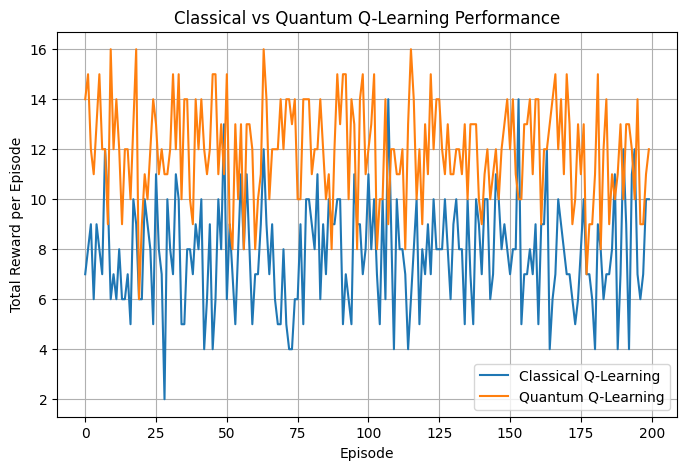

In [11]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    label="Classical Q-Learning"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    label="Quantum Q-Learning"
)

plt.xlabel("Episode")
plt.ylabel("Total Reward per Episode")
plt.title("Classical vs Quantum Q-Learning Performance")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
results = pd.DataFrame({
    "Model": ["Classical Q-Learning", "Quantum Q-Learning"],
    "Average Episode Reward": [
        np.mean(metrics_classical["performance"]),
        np.mean(metrics_quantum["performance"])
    ],
    "Final Episode Reward": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ]
})

results


,Model,Average Episode Reward,Final Episode Reward
0,Classical Q-Learning,7.815,10.0
1,Quantum Q-Learning,11.950,12.0


Paper framing:
“Instead of a Q-table, the action-value function is approximated by a variational quantum circuit.”